In [14]:
import json
import numpy as np
import pandas as pd
import os
import plotly.graph_objs as go
import simpy
import sys
from IPython.display import display
sys.path.append(r"D:\repos\opencl_sim\src")

import openclsim.plot as plot
import openclsim.core as core
from openclsim.plot.superlog import get_superlog_with_critical_path, SuperLog



In [15]:
class MockAct(core.Identifiable, core.Log):
    def __init__(self,log, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.log = log

class MockObject(core.HasContainer, core.Identifiable):
    def __init__(self,log, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.log = log

In [16]:
def as_df(obj, id_map={}):
    df = plot.get_log_dataframe(obj, id_map).set_index("Activity", drop=False)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    starts = (
        df[df["ActivityState"] == "START"]
        .filter(["Activity", "Timestamp", "geometry", "container level"])
        .rename(
            columns={
                "Timestamp": "Timestamp start",
                "geometry": "geometry start",
                "container level": "container level start",
            }
        )
    )
    stops = (
        df[df["ActivityState"] == "STOP"]
        .filter(["Timestamp", "geometry", "container level"])
        .rename(
            columns={
                "Timestamp": "Timestamp stop",
                "geometry": "geometry stop",
                "container level": "container level stop",
            }
        )
    )
    df = pd.concat([starts, stops], axis=1).reset_index(drop=True)
    df["duration"] = (
        df["Timestamp stop"] - df["Timestamp start"]
    ).dt.total_seconds() / 3600

    df["ActivityType"] = df["Activity"].apply(lambda x: x.split(" ")[0])
    df["ActivityName"] = df["Activity"].apply(lambda x: x.split(" ")[1])
    df["Vessel"] = df["Activity"].apply(lambda x: x.split(" ")[2])
    df["Location"] = df["Activity"].apply(lambda x: x.split(" ")[3])

    return df

def get_color(a):
    if a == "day_work":
        return "rgb(37,58,121)"
    if a == "night_work":
        return "rgb(86,111,186)"
    if a == "increased_night_work":
        return "rgb(136,165,252)"
    if a == "initial_mob":
        return "rgb(55,125,5)"
    if a == "night_mob":
        return "rgb(255,135,2)"
    if a == "night_demob":
        return "rgb(255,185,107)"
    if a == "delay":
        return "rgb(178,34,34)"
    if a == "wait_for_start":
        return "rgb(178,34,113)"
    return "rgb(63, 63, 63)"

def get_gantt_chart(vessels, id_map):
    df_total = pd.concat([as_df(v, id_map) for v in vessels if v.log["Timestamp"]])
    df_total["label"] = df_total.Activity.apply(lambda x: f'{" ".join(x.split()[2:4])}')
    df_total["None"] = None

    df_total = df_total[~df_total["duration"].isna()]

    traces = []
    for (vessel, activity_type), group in df_total.groupby(["Vessel", "ActivityType"]):
        x = (
            group[["Timestamp start", "Timestamp stop", "Timestamp stop"]]
            .values.flatten()
            .tolist()
        )
        x = (np.array(x) / 1e9).astype("datetime64[s]")

        y = group[["label", "label", "None"]].values.flatten().tolist()
        text = group[["Activity", "Activity", "None"]].values.flatten().tolist()

        color = get_color(activity_type)
        traces.append(
            dict(
                name=f"{vessel} {activity_type}",
                x=x,
                y=y,
                text=text,
                mode="lines",
                hovertemplate="<b>%{y}</b><br>"
                f"<b>{activity_type}</b><br>"
                "<b>%{text}</b>"
                "<br><br> %{xaxis.title.text}: "
                "%{x}<br> <extra></extra>",
                line=dict(color=color, width=10),
                connectgaps=False,
            )
        )

    dt_min = df_total["Timestamp start"].min()
    dt_max = df_total["Timestamp stop"].max()
        
    layout = dict(
        title="Vessel planning",
        hovermode="closest",
        # showlegend=False,
        xaxis=dict(
            title="Time",
            titlefont=dict(family="Courier New, monospace", size=18, color="#7f7f7f"),
            range=[dt_min.isoformat(), dt_max.isoformat()],
        ),
        yaxis=dict(
            title="Activities",
            titlefont=dict(family="Courier New, monospace", size=18, color="#7f7f7f"),
            automargin=True,
        ),
    )

    return go.Figure(data=traces, layout=layout)


In [17]:
simulation_start = 0
env = simpy.Environment(initial_time=simulation_start)

In [18]:
activities = []
for a in os.listdir('objects/activities/'):
    with open(f"objects/activities/{a}", 'r') as fp:
        data = json.load(fp)
        activities.append(MockAct(env=env, **data))
        
registry = {
    'id':{a.id:{a} for a in activities},
    'name':{a.name:{a} for a in activities},
}
id_map = {a_id.id: name for name, ids in registry["name"].items() for a_id in ids}

In [19]:
sites = []
for a in os.listdir('objects/sites/'):
    with open(f"objects/sites/{a}", 'r') as fp:
        data = json.load(fp)
        sites.append(MockObject(env=env, **data))
        
dump = next(s for s in sites if s.name == 'dump')
sites = [s for s in sites if s.name != 'dump']

In [20]:
vessels = []
for a in os.listdir('objects/vessels/'):
    with open(f"objects/vessels/{a}", 'r') as fp:
        data = json.load(fp)
        vessels.append(MockObject(env=env, **data))

In [21]:
get_gantt_chart(vessels, id_map)

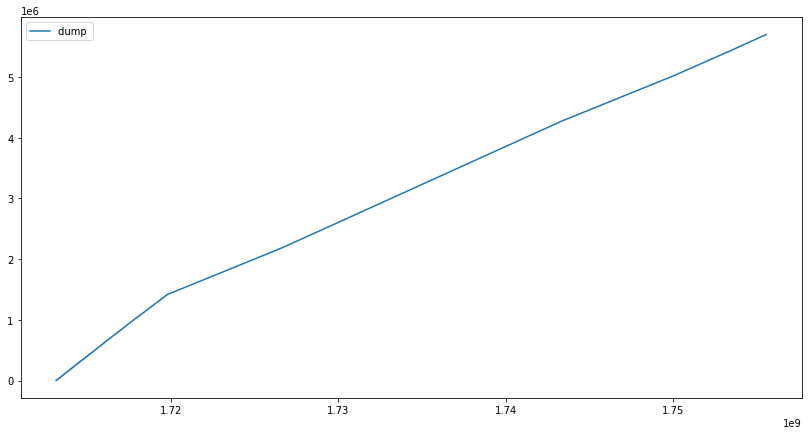

In [9]:
fig = plot.get_step_chart([dump])

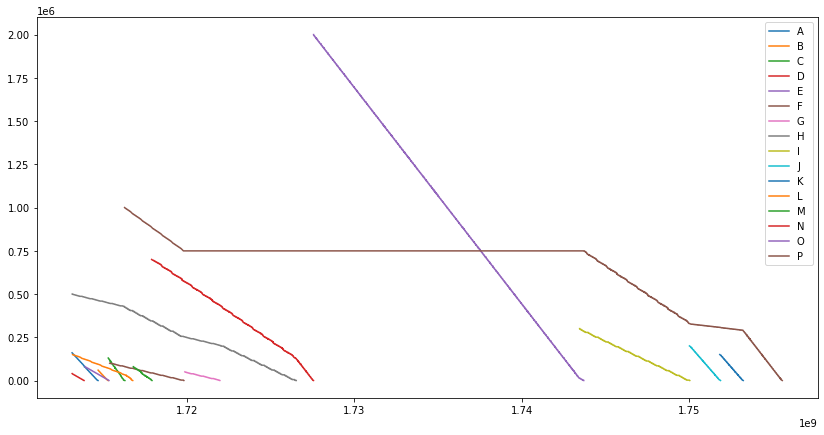

In [22]:
fig =plot.get_step_chart(sites)

In [23]:
# compute critical path, show content 'superlog'
df_superlog = get_superlog_with_critical_path([*vessels, *sites], id_map=activities)
display(df_superlog)

-- total elapsed time 6.476039886474609 seconds


Activity SourceObject    start_time  \
0     day_work activity_035 hopper1 A 1713139200.0            A  1.713139e+09   
1     day_work activity_035 hopper1 A 1713139200.0      hopper1  1.713139e+09   
2     initial_mob activity_001 wid1 D 1713139200.0         wid1  1.713139e+09   
3     initial_mob activity_021 wid2 H 1713139200.0         wid2  1.713139e+09   
4        day_work activity_001 wid1 D 1713139200.0            D  1.713143e+09   
...                                            ...          ...           ...   
6390   night_work activity_020 wid1 P 1755475200.0         wid1  1.755518e+09   
6391   night_work activity_034 wid2 P 1755475200.0         wid2  1.755518e+09   
6392     day_work activity_034 wid2 P 1755561600.0            P  1.755562e+09   
6393     day_work activity_034 wid2 P 1755561600.0         wid2  1.755562e+09   
6394        delay activity_034 wid2 P 1755561600.0         wid2  1.755584e+09   

       state  duration      end_time    cp_activity_id  is_critical  
0     ACTIVE   43200.0  1.713182e+09  cp_activity_1361         True  
1     ACTIVE   43200.0  1.713182e+09  cp_activity_1361         True  
2     ACTIVE    4200.0  1.713143e+09  cp_activity_1662         True  
3     ACTIVE    5400.0  1.713145e+09  cp_activity_1675         True  
4     ACTIVE   39000.0  1.713182e+09     cp_activity_2         True  
...      ...       ...           ...               ...          ...  
6390  ACTIVE   43200.0  1.755562e+09  cp_activity_3119         True  
6391  ACTIVE   43200.0  1.755562e+09  cp_activity_3609         True  
6392  ACTIVE   21900.0  1.755584e+09  cp_activity_1360         True  
6393  ACTIVE   21900.0  1.755584e+09  cp_activity_1360         True  
6394  ACTIVE   64500.0  1.755648e+09  cp_activity_1478         True  

[6395 rows x 8 columns]

In [24]:
# cleanup activity column for this case
for idx, row in df_superlog.iterrows():
    df_superlog.loc[idx, "Activity"] = \
        str(df_superlog.loc[idx, "Activity"])[:str(df_superlog.loc[idx, "Activity"]).index("activity")]

In [25]:
# and plot(ly)
my_log_object = SuperLog(df_superlog)
my_log_object.make_gantt_plotly()
